In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab.patches import cv2_imshow # cv2_imshow(img)
import cv2
import urllib.request
import numpy as np
import time
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import PIL.Image
import matplotlib.image as img
import IPython.display as display

In [3]:
def model_layers(layer_names): # 전역 변수, StyleContentModel에 이용
    """ 중간층의 출력값을 배열로 반환하는 < > 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 < > 모델을 불러옵니다
    # ✅ 모델 선택 가능  tf.keras.applications 문서 참고
    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    model.trainable = False    
    outputs = [model.get_layer(name).output for name in layer_names]
    model_ = tf.keras.Model([model.input], outputs)
    return model_

In [4]:
def load_img(path_to_img): # main, 전역변수
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img, new_shape   

In [5]:
# content_layers, style_layers 에서 layer name 정의 시 참고
m = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

for l in m.layers:
  print(l.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [6]:
# 전역 변수
# ✅ 모델 바꿀 시 변경 필요
content_layers = ['conv5_block2_out']  # style_content_loss, 전역변수  extractor
style_layers = [
                'conv2_block3_out',
                'conv3_block4_out',
                'conv4_block6_out', 
                'conv5_block3_out', 
                ]     # style_content_loss, 전역변수 extractor

style_location = '/content/drive/MyDrive/Colab Notebooks/data/style/udnie.jpg'
style_image, style_shape = load_img(style_location) # style_content_loss, 전역변수 style_outputs

style_extractor = model_layers(style_layers)
style_outputs = style_extractor(style_image*255) # style_content_loss, StyleContentModel

In [7]:
def gram_matrix(input_tensor): # StyleContentModel
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [8]:
class StyleContentModel(tf.keras.models.Model): # 전역변수 extractor
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model =  model_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    # ✅ 모델 바꿀 시 변경 필요
    preprocessed_input =  tf.keras.applications.resnet50.preprocess_input(inputs)
    #
    outputs = self.model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [9]:
extractor = StyleContentModel(style_layers, content_layers) # style_content_loss, train_step

In [10]:
def clip_0_1(image):  # train_step
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [11]:
def style_content_loss(outputs):  # train_step
    style_targets = extractor.call(style_image)['style']
    content_targets = extractor.call(content_image)['content']
    # ✅ hyper parameter
    style_weight=1e4
    content_weight=1e-2
    #
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [12]:
def tensor_to_image(tensor): # get_transformed_img
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [13]:
# ⚠️⚠️⚠️⚠️ vgg 모델 이외의 모델 이용 시 해당 함수 작동 안됨(이미지 변형 안됨) ⚠️⚠️⚠️
def train_step(image):  # get_transformed_img
    with tf.GradientTape() as tape:
        outputs = extractor.call(image)
        loss = style_content_loss(outputs)

    # ✅ optimizer 선택 가능
    opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    print("이미지 업데이트 결과 : ")
    display.display(tensor_to_image(image))
    # image.assign(clip_0_1(image))
    # display.display(tensor_to_image(image))
    return image

In [14]:
def get_transformed_img(content_image): # main
    image = tf.Variable(content_image)
    # ✅ hyper parameter
    epochs = 10
    steps_per_epoch = 1
    step = 0
    #
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            trained_image = train_step(image)
            print(".", end='')
        # display.clear_output(wait=True)
        # display.display(tensor_to_image(trained_image))
        # print("훈련 스텝: {}".format(step)) 
    img_transformed = np.array(tensor_to_image(trained_image))
    return img_transformed

이미지 업데이트 결과 : 


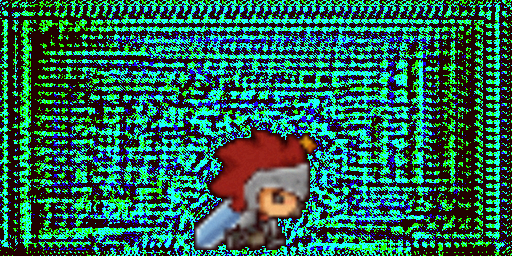

.이미지 업데이트 결과 : 


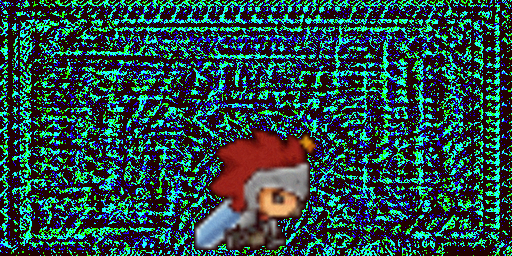

.이미지 업데이트 결과 : 


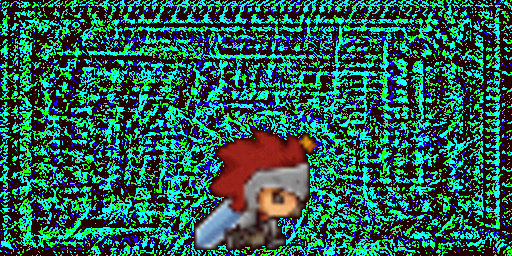

.이미지 업데이트 결과 : 


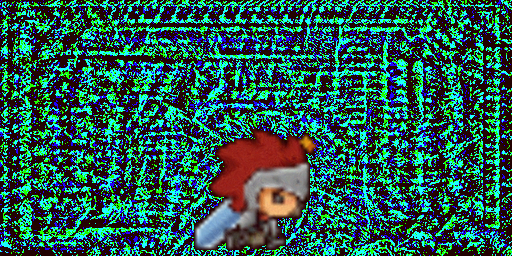

.이미지 업데이트 결과 : 


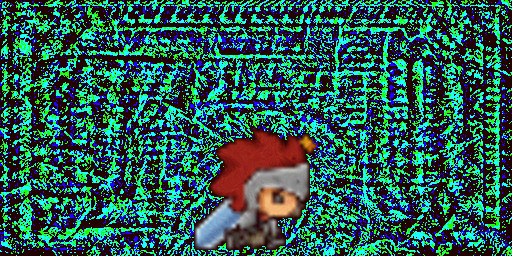

.

KeyboardInterrupt: ignored

In [15]:
# # main code
# 에셋출처 : https://assetstore.unity.com/packages/2d/characters/knight-sprite-sheet-free-93897#content
dash_1 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e0.11128ebc-b5af-4a57-9f30-7ff1248c7ee2.png'
dash_2 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e2.e4f4f2d4-547f-47af-a24b-b0c46368f69b.png'
dash_3 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f472.8fb14c53-318c-46dc-a7d6-190c6234f499.png'
imgUrls = [dash_1, dash_2, dash_3]

import time
start = time.time()

for idx, elem in enumerate(imgUrls):
    url = 'https:' + elem
    filename = 'mobileNet_' + str(idx+1)
    location = f'/content/drive/MyDrive/Colab Notebooks/data/model_test/{filename}.png'
    urllib.request.urlretrieve(url, location)

    origin_image = img.imread(location)
    origin_image = np.array(tensor_to_image(origin_image))
    origin_image_shape = origin_image.shape

    # style transfer
    content_image, content_shape = load_img(location) 
    img_transformed = get_transformed_img(content_image)

    # model이 반환한 이미지와 사이즈 동일하게 origin image 변환
    shape = content_shape.numpy()
    x, y = shape
    origin_image_resized = cv2.resize(origin_image, dsize=(y,x))

    # alpha channel 추가
    final = cv2.cvtColor(img_transformed, cv2.COLOR_RGB2RGBA)
    final[:, :, 3] = origin_image_resized[:,:,3]

    # final image 사이즈를 original image 사이즈로 변환
    x, y = origin_image_shape[0], origin_image_shape[1]
    final = cv2.resize(final, dsize=(y,x))

    cv2.imwrite(f'/content/drive/MyDrive/Colab Notebooks/data/model_test/{filename}_final.png', final)
    cv2_imshow(origin_image)
    cv2_imshow(origin_image_resized)
    cv2_imshow(img_transformed)
    cv2_imshow(final)

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))